# Лабораторная работа №3

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.io import imread
from scipy.special import expit, softmax, xlogy
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

plt.rcParams["figure.figsize"] = (20,10)

Загружаем данные и разделяем на обучающий и тестовый сеты.

In [41]:
df = pd.read_csv('2_features/1.csv')
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

Создадим классификатор на основе многослойной нейронной сети.

In [42]:
class NNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(50,), dropout_prob=None, hidden_activation='relu', out_activation='softmax',
                 l_rate=1e-1, epochs=10, eps=10e-4, batch_size=-1, verbose=False, history=False):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_prob = dropout_prob
        self.hidden_activation = hidden_activation
        self.out_activation = out_activation
        self.l_rate = l_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.history = history


    def init_weights(self, in_features, out_features):
        d = np.sqrt(3 / (in_features + 1))
        weights = np.random.uniform(-d, d, (in_features, out_features))
        biases = np.random.uniform(-d, d, out_features)
        return weights, biases    


    def init_params(self, X, y):
        hidden_layer_sizes = list(self.hidden_layer_sizes)
        self.n_out = y.shape[1]
        self.net_sizes = [X.shape[1]] + hidden_layer_sizes + [self.n_out]
        self.net_len = len(self.net_sizes)

        self.weights = []
        self.biases = []
        
        for i in range(self.net_len - 1):
            weights, biases = self.init_weights(self.net_sizes[i], self.net_sizes[i + 1])
            self.weights.append(weights)
            self.biases.append(biases)

        if self.out_activation == 'logsig':
            squared_loss = lambda y_true, y_pred: np.sum((y_true - y_pred) ** 2) / 2
            self.loss_func = squared_loss
        else:
            cross_entropy_loss = lambda y_true, y_pred: -xlogy(y_true, y_pred).sum()
            self.loss_func = cross_entropy_loss


    def forward_pass(self, activations, weights, biases, is_training=False):
        hidden_activation = ACTIVATIONS_MAP[self.hidden_activation]

        last_ind = self.net_len - 1
        
        for i in range(last_ind):
            activations[i + 1] = np.dot(activations[i], weights[i])
            activations[i + 1] += biases[i]
            
            if (i + 1) != (last_ind):
                activations[i + 1] = hidden_activation(activations[i + 1])
            
            if (i + 1) == (last_ind - 1):
                if is_training and (self.dropout_prob is not None):
                    q = 1 - self.dropout_prob
                    self.dropout_mask = np.random.binomial(1, q, activations[i + 1].shape) / q
                    activations[i + 1] *= self.dropout_mask

        out_activation = ACTIVATIONS_MAP[self.out_activation]
        activations[i + 1] = out_activation(activations[i + 1])

        return activations

    def compute_grad(self, layer, n_samples, activations, deltas, weights_grads, biases_grads):
        weights_grads[layer] = np.dot(activations[layer].T, deltas[layer]) / n_samples
        biases_grads[layer] = np.mean(deltas[layer], 0)

        return weights_grads, biases_grads

    def backprop(self, X, y, activations, deltas, weights_grads, biases_grads):
        n_samples = X.shape[0]
        loss_val = self.loss_func(y, activations[-1])

        last_n = self.net_len - 2
        deltas[last_n] = activations[-1] - y

        if (self.out_activation == 'logsig'):
            out_deriv = DERIVATIVES_MAP[self.out_activation]
            deltas[last_n] *= out_deriv(activations[-1])
        weights_grads, biases_grads = self.compute_grad(last_n, n_samples, activations, deltas, weights_grads, biases_grads)

        for i in range(self.net_len - 2, 0, -1):
            deltas[i - 1] = np.dot(deltas[i], self.weights[i].T)
            deriv_fun = DERIVATIVES_MAP[self.hidden_activation]            
            deltas[i - 1] *= deriv_fun(activations[i])
            if (i - 1) == (last_n - 2):
                    deltas[i - 1] *= self.dropout_mask
                    activations[i - 1] *= self.dropout_mask
            weights_grads, biases_grads = self.compute_grad(i - 1, n_samples, activations, deltas, weights_grads, biases_grads)

        return loss_val, weights_grads, biases_grads       


    def fit(self, X, y):
        X, y = check_X_y(X, y, multi_output=True)
        check_classification_targets(y)

        if y.ndim == 1:
            y = y.reshape((-1, 1))
            
        self.label_binarizer = OneHotEncoder(handle_unknown='ignore')

        self.label_binarizer.fit(y)
        y = self.label_binarizer.transform(y).toarray()
        self.init_params(X, y)

        def batch_split(X, y, batch_size):
            data_size = y.shape[0]
            if batch_size == -1:
                batch_size = data_size

            packs_cnt = int(data_size / batch_size) + 1
            X_batchs = np.array_split(X, packs_cnt)
            y_batchs = np.array_split(y, packs_cnt)
            return X_batchs, y_batchs

        X_batchs, y_batchs = batch_split(X, y, self.batch_size)
        batch_cnt = len(y_batchs)
        
        activations = [X] + [None] * (self.net_len - 1)
        deltas = [None] * (len(activations) - 1)
        
        weights_grads = [np.empty((self.net_sizes[i], self.net_sizes[i + 1])) for i in range(self.net_len - 1)]
        biases_grads = [np.empty(self.net_sizes[i + 1]) for i in range(self.net_len - 1)]
        self.params_history = []
        self.loss_curve = []
        self.dropout_mask = None

        for epoch in range(self.epochs):
            sum_loss = 0.0
            for i in range(batch_cnt):
                activations[0] = X_batchs[i]
                activations = self.forward_pass(activations, self.weights, self.biases, is_training=True)
                
                loss, weights_grads, biases_grads = self.backprop(X_batchs[i], y_batchs[i], activations,
                                                                   deltas, weights_grads, biases_grads)
                sum_loss += loss

                self.weights = [w - self.l_rate * grad for w, grad in zip(self.weights, weights_grads)]
                self.biases = [b - self.l_rate * grad for b, grad in zip(self.biases, biases_grads)]       

            sum_loss /= X.shape[0]
            self.loss_curve.append(sum_loss)
            if self.history:
                self.params_history.append((self.weights, self.biases))

            if self.verbose:
                print(f'Epoch: {epoch}, loss: {sum_loss}')

        return self

    def predict(self, X, weights=None, biases=None):
        if weights is None:
            weights = self.weights
        
        if biases is None:
            biases = self.biases

        check_is_fitted(self, [])
        X = check_array(X)

        activations = [X]
        for i in range(self.net_len - 1):
            activations.append(np.empty((X.shape[0], self.net_sizes[i + 1])))

        self.forward_pass(activations, weights, biases)
        y_pred = activations[-1]
        
        if self.n_out == 1:
            y_pred = y_pred.ravel()

        return self.label_binarizer.inverse_transform(y_pred)
    
    def score(self, X, y, weights=None, biases=None):
        return accuracy_score(y, self.predict(X, weights, biases))
    
    def accuracy_curve(self, X, y):
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        y = self.label_binarizer.transform(y).toarray()
        accuracy = []
        for w, b in self.params_history:
            y_trans = self.label_binarizer.inverse_transform(y)
            accuracy.append(self.score(X, y_trans, w, b))

        return accuracy


    def softmax(x):
        tmp = x - x.max(axis=1)[:, np.newaxis]
        x = np.exp(tmp)
        x /= x.sum(axis=1)[:, np.newaxis]
        return x


    ACTIVATIONS_MAP = {
        'logsig': expit,
        'tanh': np.tanh,
        'relu': lambda x: np.maximum(x, 0),
        'softmax': softmax
    }


    DERIVATIVES_MAP = {
        'logsig': lambda x: x * (1 - x),
        'tanh': lambda x: 1 - x * x,
        'relu': lambda x: (x >= 0) * 1
    }

In [43]:
def plot_stat(hidden_activation, N_epochs=200):
    def help_plot(axes, hidden, output):
        b_clf = lambda x: NNClassifier(hidden_layer_sizes=(x,), batch_size=100,  epochs=N_epochs,
                                       hidden_activation=hidden, out_activation=output, l_rate=0.1, history=True)
        clfs = [b_clf(i) for i in [2, 8, 16]]
        accs = dict()
        for clf in clfs:
            hn_size = clf.hidden_layer_sizes[0]
            clf.fit(X_train, y_train)
            axes[0].plot(clf.loss_curve, label=f'hidden neurons= {hn_size}')
            axes[0].grid()
            axes[0].set_xlabel('epochs')
            axes[0].set_ylabel('Error')
            axes[0].set_title(f'Error: {hidden_activation} + {output}')
            axes[0].legend()
            
            accuracy_curve = clf.accuracy_curve(X_test, y_test)
            axes[1].plot(accuracy_curve, label=f'hidden neurons = {hn_size}')
            axes[1].grid()
            axes[1].set_xlabel('epochs')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title(f'Test accuracy: {hidden_activation} + {output}')
            axes[1].legend()
            
            accs[hn_size] = accuracy_curve[-1]
        
        best_hn = max(accs, key=accs.get)            
        print(f'Best accuracy for {hidden} + {output}, hidden neurons = {best_hn}: {accs[best_hn]:.3f}')


    _, axs = plt.subplots(2, 2)
    help_plot(axs[0], hidden_activation, 'logsig')
    help_plot(axs[1], hidden_activation, 'softmax')

Проведем эксперименты для разных комбинаций слоев и количества нейронов внутреннего слоя.

Best accuracy for relu + logsig, hidden neurons = 8: 0.890
Best accuracy for relu + softmax, hidden neurons = 2: 0.883


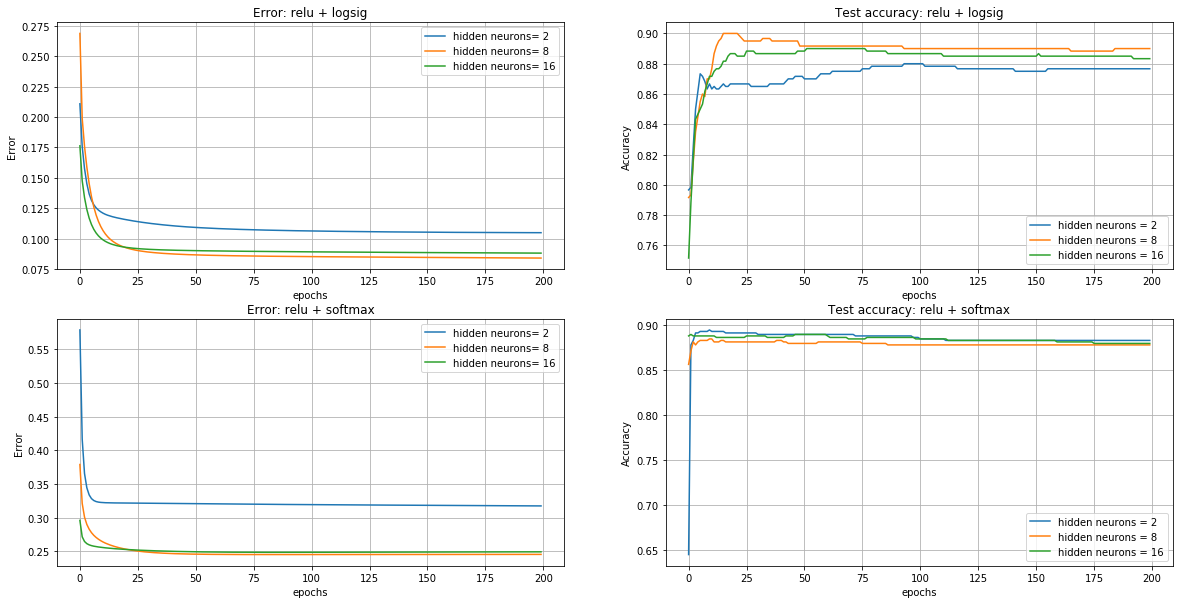

In [65]:
plot_stat('relu', N_epochs=200)

Best accuracy for logsig + logsig, hidden neurons = 16: 0.892
Best accuracy for logsig + softmax, hidden neurons = 2: 0.895


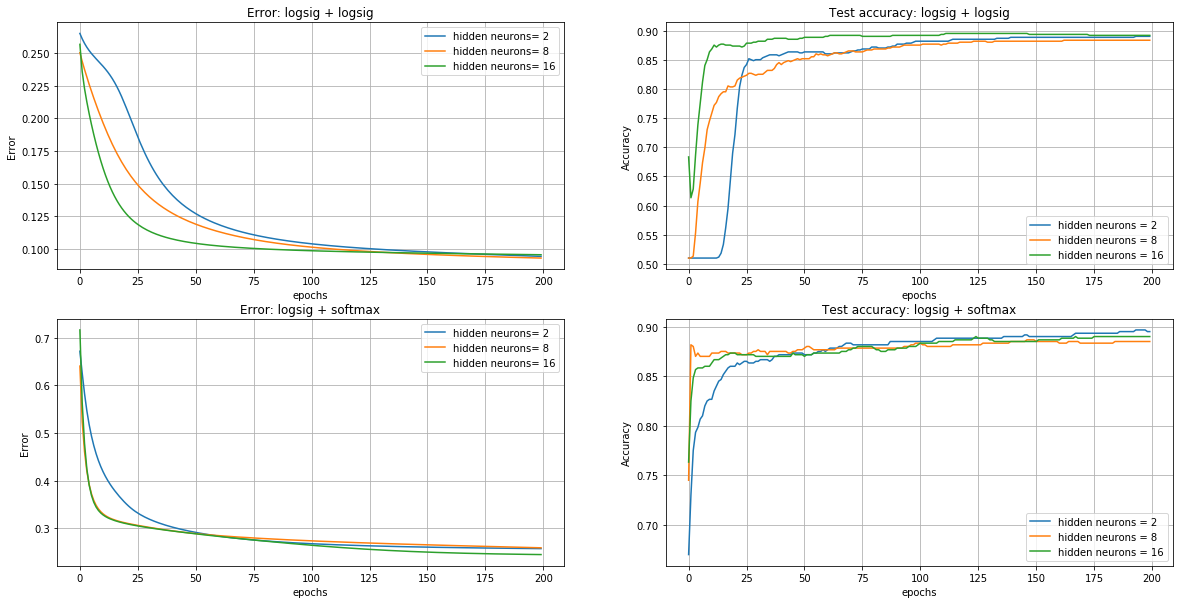

In [67]:
plot_stat('logsig', N_epochs=200)

Best accuracy for tanh + logsig, hidden neurons = 8: 0.893
Best accuracy for tanh + softmax, hidden neurons = 8: 0.902


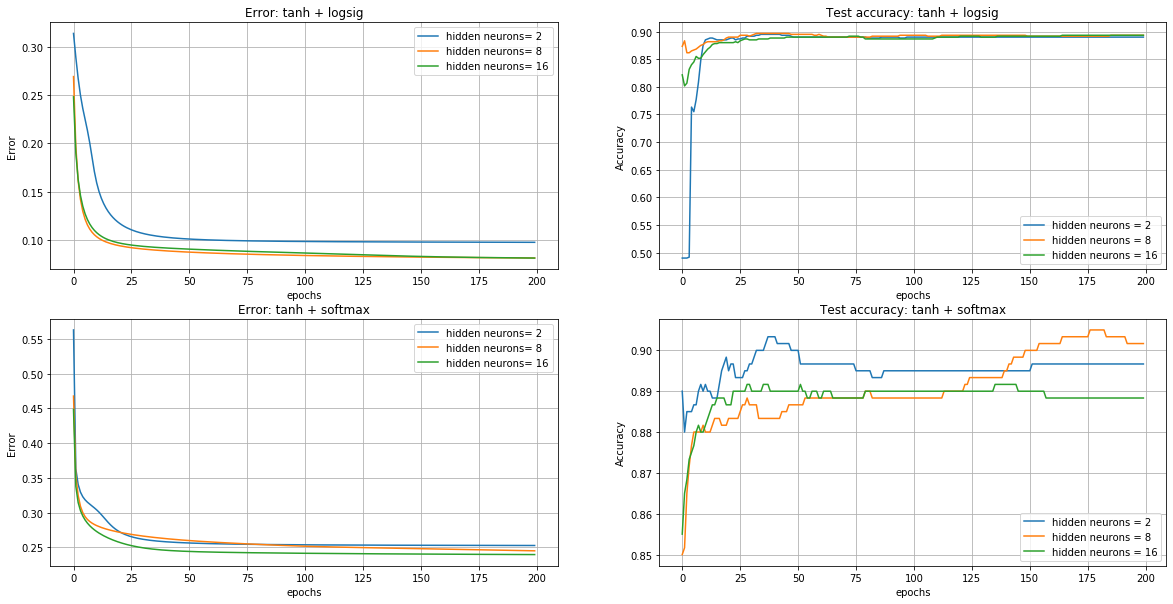

In [68]:
plot_stat('tanh', N_epochs=200)

Наилучших результатов удалось добиться при использовании функции `tanh` на внутреннем слое, `softmax` на выходном и количеством нейронов внутреннего слоя 8. Точность составила 90.2%. В целом, все комбинации дали схожие результаты.

Загружаем notMNIST сет

In [40]:
X_mnist = []
y_mnist = []

for root, dirs, files in os.walk('notMNIST'):
    for im in files:
        label = os.path.dirname(os.path.join(root, im))[-1]
        image = imread(os.path.join(root, im))
        X_mnist.append(image)
        y_mnist.append(label)

num_samples = len(X_mnist)
print('Number of images: ', num_samples)

Number of images:  18724


In [38]:
X = np.asarray(X_mnist, dtype=np.float).reshape((num_samples, -1)) / 255
y = np.asarray(y_mnist)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [11]:
def get_best_model(estimator, param_grid):
    grid_model = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_

    print(f'Best params: {grid_model.best_params_}')
    print(f'Train accuracy: {best_model.score(X_train, y_train)}')
    print(f'Test accuracy: {best_model.score(X_test, y_test)}')
    
    return best_model

Подберем параметр градиентного спуска с помощью кросс-валидации.

In [12]:
params = {
    'l_rate': np.geomspace(1e-1, 1, 5),    
}

mlp_model = NNClassifier(hidden_layer_sizes=(4096,), epochs=10, verbose=False, batch_size=200,
                   hidden_activation='relu', out_activation='softmax')
l_rate_best_model = get_best_model(mlp_model, params)

/home/skatkov/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/skatkov/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Best params: {'l_rate': 0.1}
Train accuracy: 0.9250951331864611
Test accuracy: 0.9086782376502003


In [13]:
def plot_graphics(clf, ax, X, y, set_name):
    accuracy_curve = clf.accuracy_curve(X, y)
    ax.plot(accuracy_curve)
    ax.grid()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{set_name} Accuracy')

Проведем эксперимент с датасетом notMNIST

Epoch: 0, loss: 0.8930739472975116
Epoch: 1, loss: 0.42250095279064614
Epoch: 2, loss: 0.38204344630522075
Epoch: 3, loss: 0.35813302959609233
Epoch: 4, loss: 0.3408043116420873
Epoch: 5, loss: 0.32704794017962957
Epoch: 6, loss: 0.3155540025045459
Epoch: 7, loss: 0.30562801150251445
Epoch: 8, loss: 0.29685593900731627
Epoch: 9, loss: 0.2889777779971936
Epoch: 10, loss: 0.28181091398076513
Epoch: 11, loss: 0.2752308612390176
Epoch: 12, loss: 0.26914554029023524
Epoch: 13, loss: 0.2634812591414515
Epoch: 14, loss: 0.2581802977228691
Epoch: 15, loss: 0.2531989061884852
Epoch: 16, loss: 0.24850131012113036
Epoch: 17, loss: 0.24405714143806448
Epoch: 18, loss: 0.23984274742954023
Epoch: 19, loss: 0.23583745167796902
Epoch: 20, loss: 0.23202221791912517
Epoch: 21, loss: 0.2283814365819453
Epoch: 22, loss: 0.22490277590891275
Epoch: 23, loss: 0.22157292928701303
Epoch: 24, loss: 0.218380096947705
Epoch: 25, loss: 0.21531369096720449
Epoch: 26, loss: 0.2123664236739137
Epoch: 27, loss: 0.2095

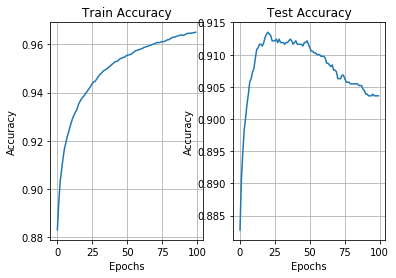

In [15]:
mlp = NNClassifier(hidden_layer_sizes=(4096,), epochs=100, verbose=True, batch_size=200,
                   hidden_activation='relu', out_activation='softmax', eps=10e-3, l_rate=0.1, history=True,
                   dropout_prob=None)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

_, (ax0, ax1) = plt.subplots(1, 2)
plot_graphics(mlp, ax0, X_train, y_train, 'Train')
plot_graphics(mlp, ax1, X_test, y_test, 'Test')

Как видим, для обучения достаточно и меньшего количества эпох, так как после примерно 25 наблюдается эффект переобучения.

Проведем эксперимент с добавлением `dropout`a.

Epoch: 0, loss: 0.8254145824099071
Epoch: 1, loss: 0.4227079224917779
Epoch: 2, loss: 0.38607465489486614
Epoch: 3, loss: 0.36417498454506597
Epoch: 4, loss: 0.3475848322628158
Epoch: 5, loss: 0.3342103599083363
Epoch: 6, loss: 0.32286767953320505
Epoch: 7, loss: 0.3125017276124911
Epoch: 8, loss: 0.3041505171783808
Epoch: 9, loss: 0.29914030909281647
Epoch: 10, loss: 0.29099968922738606
Epoch: 11, loss: 0.2846559572014274
Epoch: 12, loss: 0.27726636011420086
Epoch: 13, loss: 0.2708486452224712
Epoch: 14, loss: 0.26751005527555793
Epoch: 15, loss: 0.2611170379666213
Epoch: 16, loss: 0.25928821304405936
Epoch: 17, loss: 0.2524917012951742
Epoch: 18, loss: 0.249855903914095
Epoch: 19, loss: 0.24400364633519384
Epoch: 20, loss: 0.24170686417811266
Epoch: 21, loss: 0.23671068055313815
Epoch: 22, loss: 0.23397224278931647
Epoch: 23, loss: 0.23104629573420254
Epoch: 24, loss: 0.228648922139955
Epoch: 25, loss: 0.22423433996656766
Epoch: 26, loss: 0.21995278350281283
Epoch: 27, loss: 0.219806

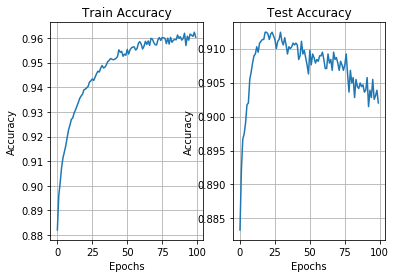

In [16]:
mlp = NNClassifier(hidden_layer_sizes=(4096,), epochs=100, verbose=True, batch_size=200,
                   hidden_activation='relu', out_activation='softmax', eps=10e-3, l_rate=.1, history=True,
                   dropout_prob=0.3)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

_, (ax0, ax1) = plt.subplots(1, 2)
plot_graphics(mlp, ax0, X_train, y_train, 'Train')
plot_graphics(mlp, ax1, X_test, y_test, 'Test')

Видим, что `dropout` не позволил добиться большей точности, а лишь привел к скачкам градиента. Возможно, на большем количестве эпох `dropout` позволил бы улучшить результат, так как он призван бороться с переобучением, которое здесь только начиналось.